### CONFIGURATION

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
import copy
import sys
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('max_colwidth',200)  #necessary for pileup files

In [2]:
# Hartwig imports
sys.path.append("/Users/peterpriestley/hmf/repos/scripts/analysisscripts") 
import analyseVCF as aVCF
import analysePileup as aPILEUP
import venn as vn

In [8]:
# BED FILE
BED_PATH = "/Users/peterpriestley/hmf/repos/pipeline/settings/slicing/"
BED_FILE_NAME = "CPCT_Slicing.bed"

# COMBINED VCF CONFIG
VCF_SAMPLE = "CPCT02040020"
VCF_PATH = "/Users/peterpriestley/hmf/analyses/160706-many-variants-in-exome/"
VCF_FILE_NAME = VCF_SAMPLE + "R_" + VCF_SAMPLE + "T_merged_somatics.vcf"
SAMPLE_NAMES = {VCF_SAMPLE + 'T.mutect':'mutect', \
                VCF_SAMPLE + 'T.freebayes':'freebayes', \
                'TUMOR.strelka':'strelka', \
                'TUMOR.varscan':'varscan'}
# PILEUP CONFIG
PILEUP_PATH = "/Users/peterpriestley/hmf/slice" + VCF_SAMPLE + "/"
NORMAL_PILEUP_FILENAME = VCF_SAMPLE + ".pileup"
TUMOR_PILEUP_FILENAME = VCF_SAMPLE + "T.pileup"

<h3> Load VCFs and Prepare DF

In [18]:
## LOAD BED
#bed = aVCF.loadBEDFile(BED_PATH,BED_FILE_NAME)

In [19]:
# LOAD PROD VCF and filter
#sampleBed = copy.deepcopy(bed)
df = aVCF.loadVaraintsFromVCF(VCF_PATH,VCF_FILE_NAME,SAMPLE_NAMES,VCF_SAMPLE,True,False)#True,sampleBed)



reading vcf file: CPCT02040020R_CPCT02040020T_merged_somatics.vcf
reading VCF File line: 100000
reading VCF File line: 200000
reading VCF File line: 300000
reading VCF File line: 400000
reading VCF File line: 500000
reading VCF File line: 600000
reading VCF File line: 700000
reading VCF File line: 800000
Number variants loaded: 843708


<h3> SLICE ANALYSIS

In [21]:
#INTERNAL 'PRECISION' + 'SENSITIVITY' per caller
outputdata = []
variantTypes = df.variantType.unique()
patientNames = df.patientName.unique()
for patientName in patientNames:
    for variantType in variantTypes:
        truthSet = len(df[(df['numCallers'] >= 2)&(df['variantType'] == variantType)&(df['patientName'] == patientName)])
        for columnName in list(df):
            if columnName.endswith('allele'):
                myCaller = columnName[:-6]
                truePositives = len(df[(df[myCaller+'allele'] != '')&(df['numCallers'] >=2) &\
                                   (df['variantType'] == variantType)&(df['patientName'] == patientName)])
                falseNegatives = len(df[(df[myCaller+'allele'] == '')&(df['numCallers'] >= 2) &\
                                    (df['variantType'] == variantType)&(df['patientName'] == patientName)])
                positives = len(df[(df[myCaller+'allele'] != '')&\
                                   (df['variantType'] == variantType)&(df['patientName'] == patientName)]) 
                if positives > 0:
                    outputdata.append([patientName,variantType, myCaller, truthSet,truePositives,\
                                   positives-truePositives, falseNegatives, \
                                   round(truePositives/float(positives),4),round(truePositives/float(truthSet),4)])
   
outputDF = pd.DataFrame(outputdata)
outputDF.columns = (['patientName','variantType','caller','truth','TP','FP','FN',\
                     'intPrecision','intSensitivity'])
outputDF.sort_values(['patientName','variantType','caller'])

,patientName,variantType,caller,truth,TP,FP,FN,intPrecision,intSensitivity
6,CPCT02040020,INDEL,freebayes,401,236,1553,165,0.1319,0.5885
4,CPCT02040020,INDEL,strelka,401,317,231,84,0.5785,0.7905
5,CPCT02040020,INDEL,varscan,401,369,1542,32,0.1931,0.9202
3,CPCT02040020,SNP,freebayes,213145,2885,9342,210260,0.2360,0.0135
2,CPCT02040020,SNP,mutect,213145,212015,364816,1130,0.3676,0.9947
0,CPCT02040020,SNP,strelka,213145,212408,250447,737,0.4589,0.9965
1,CPCT02040020,SNP,varscan,213145,7559,2231,205586,0.7721,0.0355


<h3> SNP

In [24]:
snpdf = df[(df.variantType == 'SNP')]

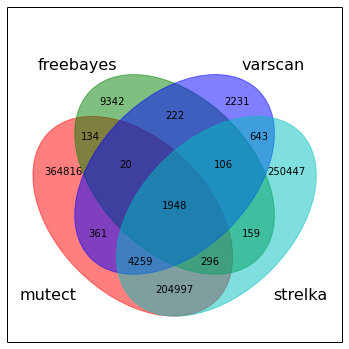

In [25]:
vn.venn([snpdf[snpdf.mutectallele != '']['chromPos'], \
         snpdf[snpdf.strelkaallele != '']['chromPos'], \
        snpdf[snpdf.freebayesallele != '']['chromPos'], \
        snpdf[snpdf.varscanallele != '']['chromPos'] \
        ],['mutect','strelka','freebayes','varscan'],figsize=(6,6))

### <hd3> Indel Venn

In [26]:
indeldf= df[(df.variantType == 'INDEL')]

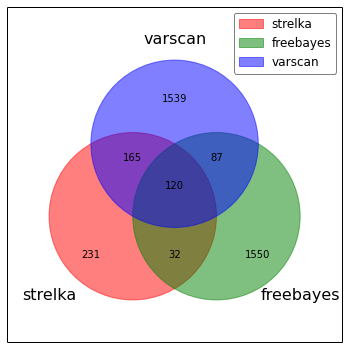

In [27]:
vn.venn([indeldf[indeldf.strelkaallele != '']['chromPos'], \
        indeldf[indeldf.freebayesallele != '']['chromPos'], \
        indeldf[indeldf.varscanallele != '']['chromPos'] \
        ],['strelka','freebayes','varscan'],figsize=(6,6))

<h3> Allelic Depth

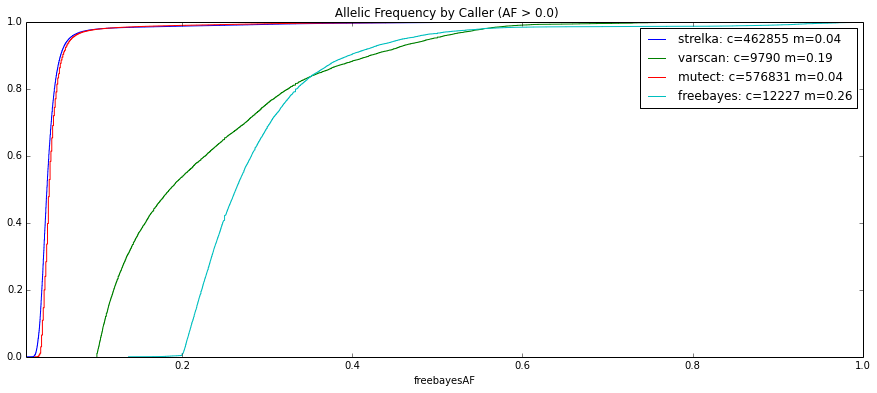

In [33]:
#Alllele Freq By Caller
for columnName in list(snpdf):
    if columnName.endswith('allele'):
        ser = snpdf[(snpdf[columnName] != '') &(snpdf[columnName[:-6] + 'AF'] > 0.0)][columnName[:-6] + 'AF']
        ser = ser.sort_values()
        #ser[len(ser)] = ser.iloc[-1]
        cum_dist = np.linspace(0.,1.,len(ser))
        ser_cdf = pd.Series(cum_dist, index=ser,name=columnName[:-6]+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
        ser_cdf.plot(drawstyle='steps',legend=True,title=" Allelic Frequency by Caller (AF > 0.0)",figsize=[15,6])

### Allelic Depth Scatter Plot

In [ ]:
caller1 = 'varscan'
caller2 = 'strelka'
tempdf = df[(df[caller1+'allele']!='')&(df[caller2+'allele']!='')]
tempdf.head()
tempdf.plot.scatter(caller1+'allelicFreq',caller2+'allelicFreq' \
                        ,figsize=[6,6] \
                        ,title="Comparison of "+caller1+" and "+caller2+" Allelic Frequency" \
                        ,xlim=[0,1],ylim=[0,1])